In [156]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
import leakage, utils
import pubchempy as pcp
import seaborn as sns

In [157]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

In [158]:
exometabolites_folder = Path("../../data/e_coli/")


In [159]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)

In [160]:
def get_leakage(time):
    exometabolites_folder = Path("../../data/e_coli/")
    leakage_df = leakage.get_leakage(exometabolites_folder, "ecoli", time = time, unit = '/gDW')
    leakage_df.set_index("Metabolite", inplace=True)
    leakage_df.drop_duplicates(inplace=True)
    leakage_label = "Leakage (mM/gDW/h)"
    return leakage_df

In [161]:
def get_turnover_flux(m, solution):
    total_flux = 0
    for r in m.reactions:
        flux_r = solution.fluxes[r.id]*r.get_coefficient(m_id)
        if flux_r > 0:
            total_flux += flux_r
    return total_flux

In [162]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# df2 = pd.merge(leakage_df, mapping_df, left_index=True, right_index=True)
# df2.drop(columns='Metabolite name', inplace=True)

# Get leakage


In [166]:
timepoints = np.arange(6, 14,1)#[5,6,7,8,9,10,11, 12, 13]
for i, time in enumerate(timepoints):
    leakage_df = get_leakage(time)
    # Consider to use an earlier time-point
    glucose_uptake_rate = leakage.get_glucose_uptake_rate(exometabolites_folder, "ecoli", time = time)
    df2 = pd.merge(leakage_df, mapping_df, left_index=True, right_index=True)
    df2.drop(columns='Metabolite name', inplace=True)
    df = pd.merge(met_info_df, df2, left_on = 'Metabolite id', right_on = 'Ecoli metabolite')
    df['Time'] = time
    df['Glucose'] = -glucose_uptake_rate
    
    # Set model constraints
    with model:
        model.reactions.EX_glc__D_e.lower_bound = min(glucose_uptake_rate, 0)
        for j, row in df.iterrows():
            if row['Leakage (mM/gDW/h)'] < 0:
                met_ids = row['Metabolite id'].split(',')
                mets = []
                for m_id in met_ids:
                    try:
                        m = model.metabolites.get_by_id('{0}_e'.format(m_id.strip(' ')))
                    except KeyError:
                        continue
                    else:
                        mets.append(m)
                for m in mets:
                    r_ex = [r for r in m.reactions if len(r.metabolites)==1][0]
                    r_ex.lower_bound = row['Leakage (mM/gDW/h)']/len(mets)
                    # Should check soplutions
                    # print(r_ex.id)
        solution = model.optimize()
        # List already excreted metabolites
        exchanged_mets = []
        for r in model.boundary:
            flux = solution.fluxes[r.id]
            if flux != 0:
                exchanged_mets.append(list(r.metabolites.keys())[0].id[:-2])
        
        # print(model.summary())
        df['Growth rate'] = solution.objective_value
        # Get turnover and shadow prices
        turnover = {}
        shadow_prices = {}        
        for j, row in df.iterrows():
            if row['Leakage (mM/gDW/h)'] > 0:
                met_ids = row['Metabolite id'].split(',')
                sp_list = []
                turnover_list = []
                for key in met_ids:
                    if key.strip() in exchanged_mets:
                        continue
                    m_id = "{0}_c".format(key.strip())
                    m = model.metabolites.get_by_id(m_id)
                    sp_list.append(leakage.estimate_shadow_price_for_met(model, m, solution, delta = 0.01))
                    turnover_list.append(get_turnover_flux(m, solution))
                # print(met_ids, sp_list, turnover_list)
                # Shadow prices
                if len(sp_list):
                    shadow_prices[j] = np.nanmean(sp_list)
                    turnover[j] = np.mean(turnover_list)
                else:
                    shadow_prices[j] = np.nan
                    turnover[j] = np.nan
                # print(met_ids, np.nanmean(sp_list))
        df["Shadow price"] = pd.Series(shadow_prices)
        df["Turnover"] = pd.Series(turnover)
        
    if i == 0:
        full_df = df
    else:
        full_df = pd.concat([full_df, df])


In [167]:
full_leakage = full_df.loc[~full_df['Shadow price'].isna(), :]
full_leakage = full_leakage.loc[full_leakage.Turnover <100, :]
full_leakage = full_leakage.loc[full_leakage['Leakage (mM/gDW/h)'] > 0, :]

In [168]:
full_leakage['log10(-leakage)'] = np.log10(full_leakage['Leakage (mM/gDW/h)'])
full_leakage['log10(Shadow price)'] = np.log10(-full_leakage['Shadow price'])
full_leakage['log10(Turnover)'] = np.log10(full_leakage['Turnover'])

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [169]:
full_leakage.Turnover


0     1.534274
1     1.168988
3     1.268731
4     2.587399
5     2.464452
        ...   
24    0.091326
25    0.091326
26    4.162970
33    0.163064
34    0.000000
Name: Turnover, Length: 197, dtype: float64

In [170]:
full_leakage.groupby('Time').mean()

,Mass,Charge,Phosphate,Topological Polar Surface Area,Concentration in E.coli,log P,Leakage (mM/gDW/h),Glucose,Growth rate,Shadow price,Turnover,log10(-leakage),log10(Shadow price),log10(Turnover)
Time,,,,,,,,,,,,,,
6,156.494175,-1.129032,0.290323,98.038710,0.005209,-2.473903,36.400256,1.534274,0.142642,-0.085030,0.879382,-0.457149,-1.125764,-inf
7,165.266823,-1.322581,0.354839,100.380645,0.001689,-2.344871,62.209485,0.684949,0.165482,-0.088023,0.637710,-0.417910,-1.109115,-inf
8,171.006084,-1.310345,0.379310,104.372414,0.005857,-2.622414,2.197651,0.319465,0.518883,-0.056891,1.753726,-0.786764,-1.397635,NaN
9,174.336042,-1.384615,0.423077,106.446154,0.001604,-2.721154,2.171843,0.184095,0.502881,-0.055875,1.785021,-0.637290,-1.381931,NaN
10,173.644740,-1.545455,0.454545,104.527273,0.001810,-2.335955,3.364183,0.141847,0.436146,-0.059662,2.465175,-0.408093,-1.332736,-inf
11,150.742692,-1.136364,0.227273,90.572727,0.006997,-2.338636,1.704040,0.056118,0.563611,-0.042488,2.157545,-0.609115,-1.523123,-inf
12,144.550347,-0.642857,0.142857,82.035714,0.009251,-2.107143,4.459792,-0.003765,0.584781,-0.061275,1.604350,-0.480233,-1.384889,-inf
13,172.377173,-1.454545,0.363636,106.540909,0.007249,-2.393182,2.992533,-0.001964,0.492946,-0.051556,2.483688,-0.548601,-1.345923,NaN


In [171]:
# full_leakage['Test'] = np.log10(full_leakage['Leakage (mM/gDW/h)'])/full_leakage['Growth rate']

# Make predictions

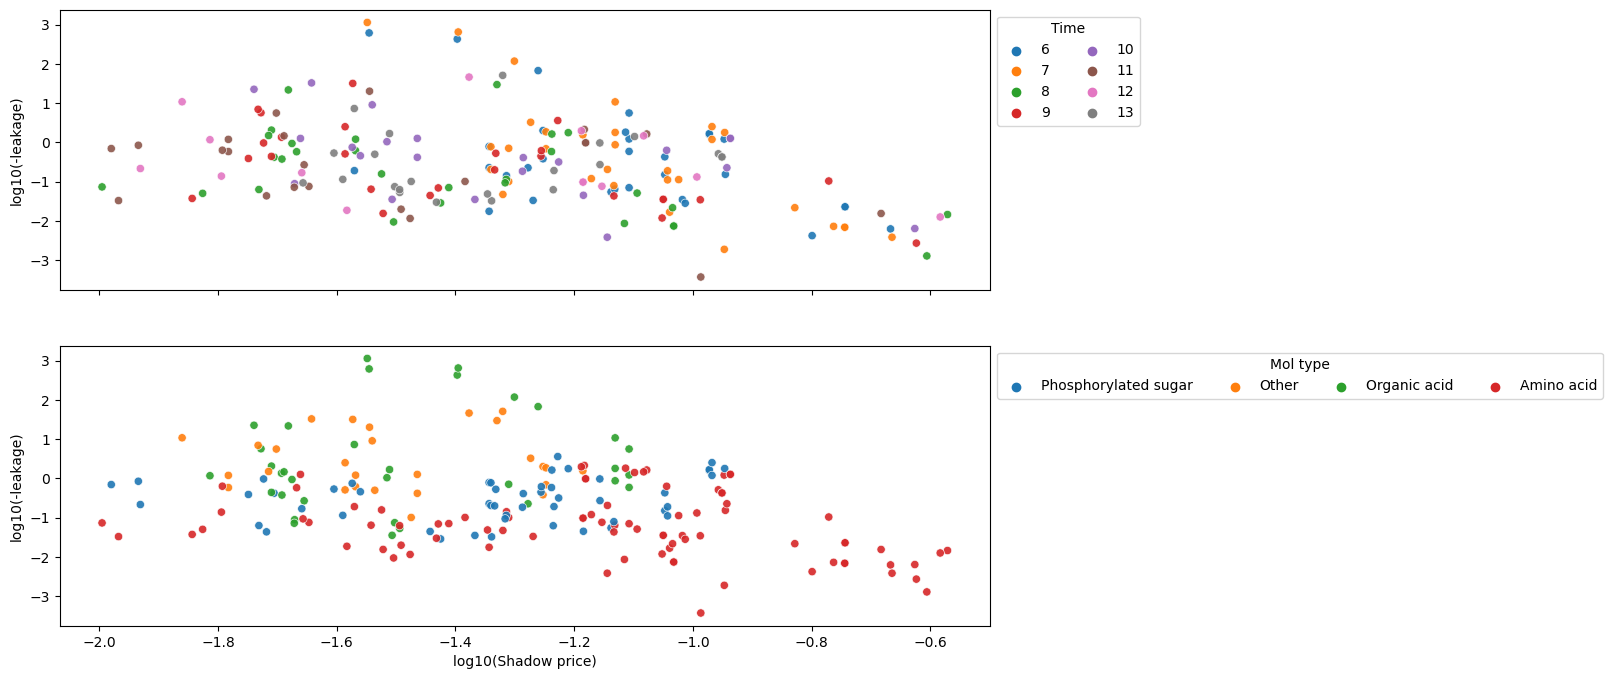

In [172]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize = (12, 8))
sns.scatterplot(data = full_leakage, x = 'log10(Shadow price)', y = 'log10(-leakage)', hue = 'Time', ax = ax1, palette = 'tab10', alpha = 0.9)
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left',ncol=2, title="Time")

sns.scatterplot(data = full_leakage, x = 'log10(Shadow price)', y = 'log10(-leakage)', hue = 'Metabolite class', ax = ax2, palette = 'tab10', alpha = 0.9)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left',ncol=4, title="Mol type")


In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ARDRegression, BayesianRidge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import AdaBoostRegressor
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor



In [174]:
full_leakage.columns

Index(['Metabolite name', 'Metabolite id', 'Mass', 'Charge', 'Phosphate',
       'Topological Polar Surface Area', 'Concentration in E.coli', 'log P',
       'Metabolite class', 'Pathway', 'Leakage (mM/gDW/h)', 'Ecoli metabolite',
       'Yeast metabolite', 'Time', 'Glucose', 'Growth rate', 'Shadow price',
       'Turnover', 'log10(-leakage)', 'log10(Shadow price)',
       'log10(Turnover)'],
      dtype='object')

In [175]:
full_leakage.reset_index(inplace = True)

In [179]:
columns = ['log10(Shadow price)', "log10(Turnover)", "Mass", "Charge", "Phosphate", 'log P', 'Time']#"Concentration", "Shadow price", "log10_conc", 'Growth rate', 


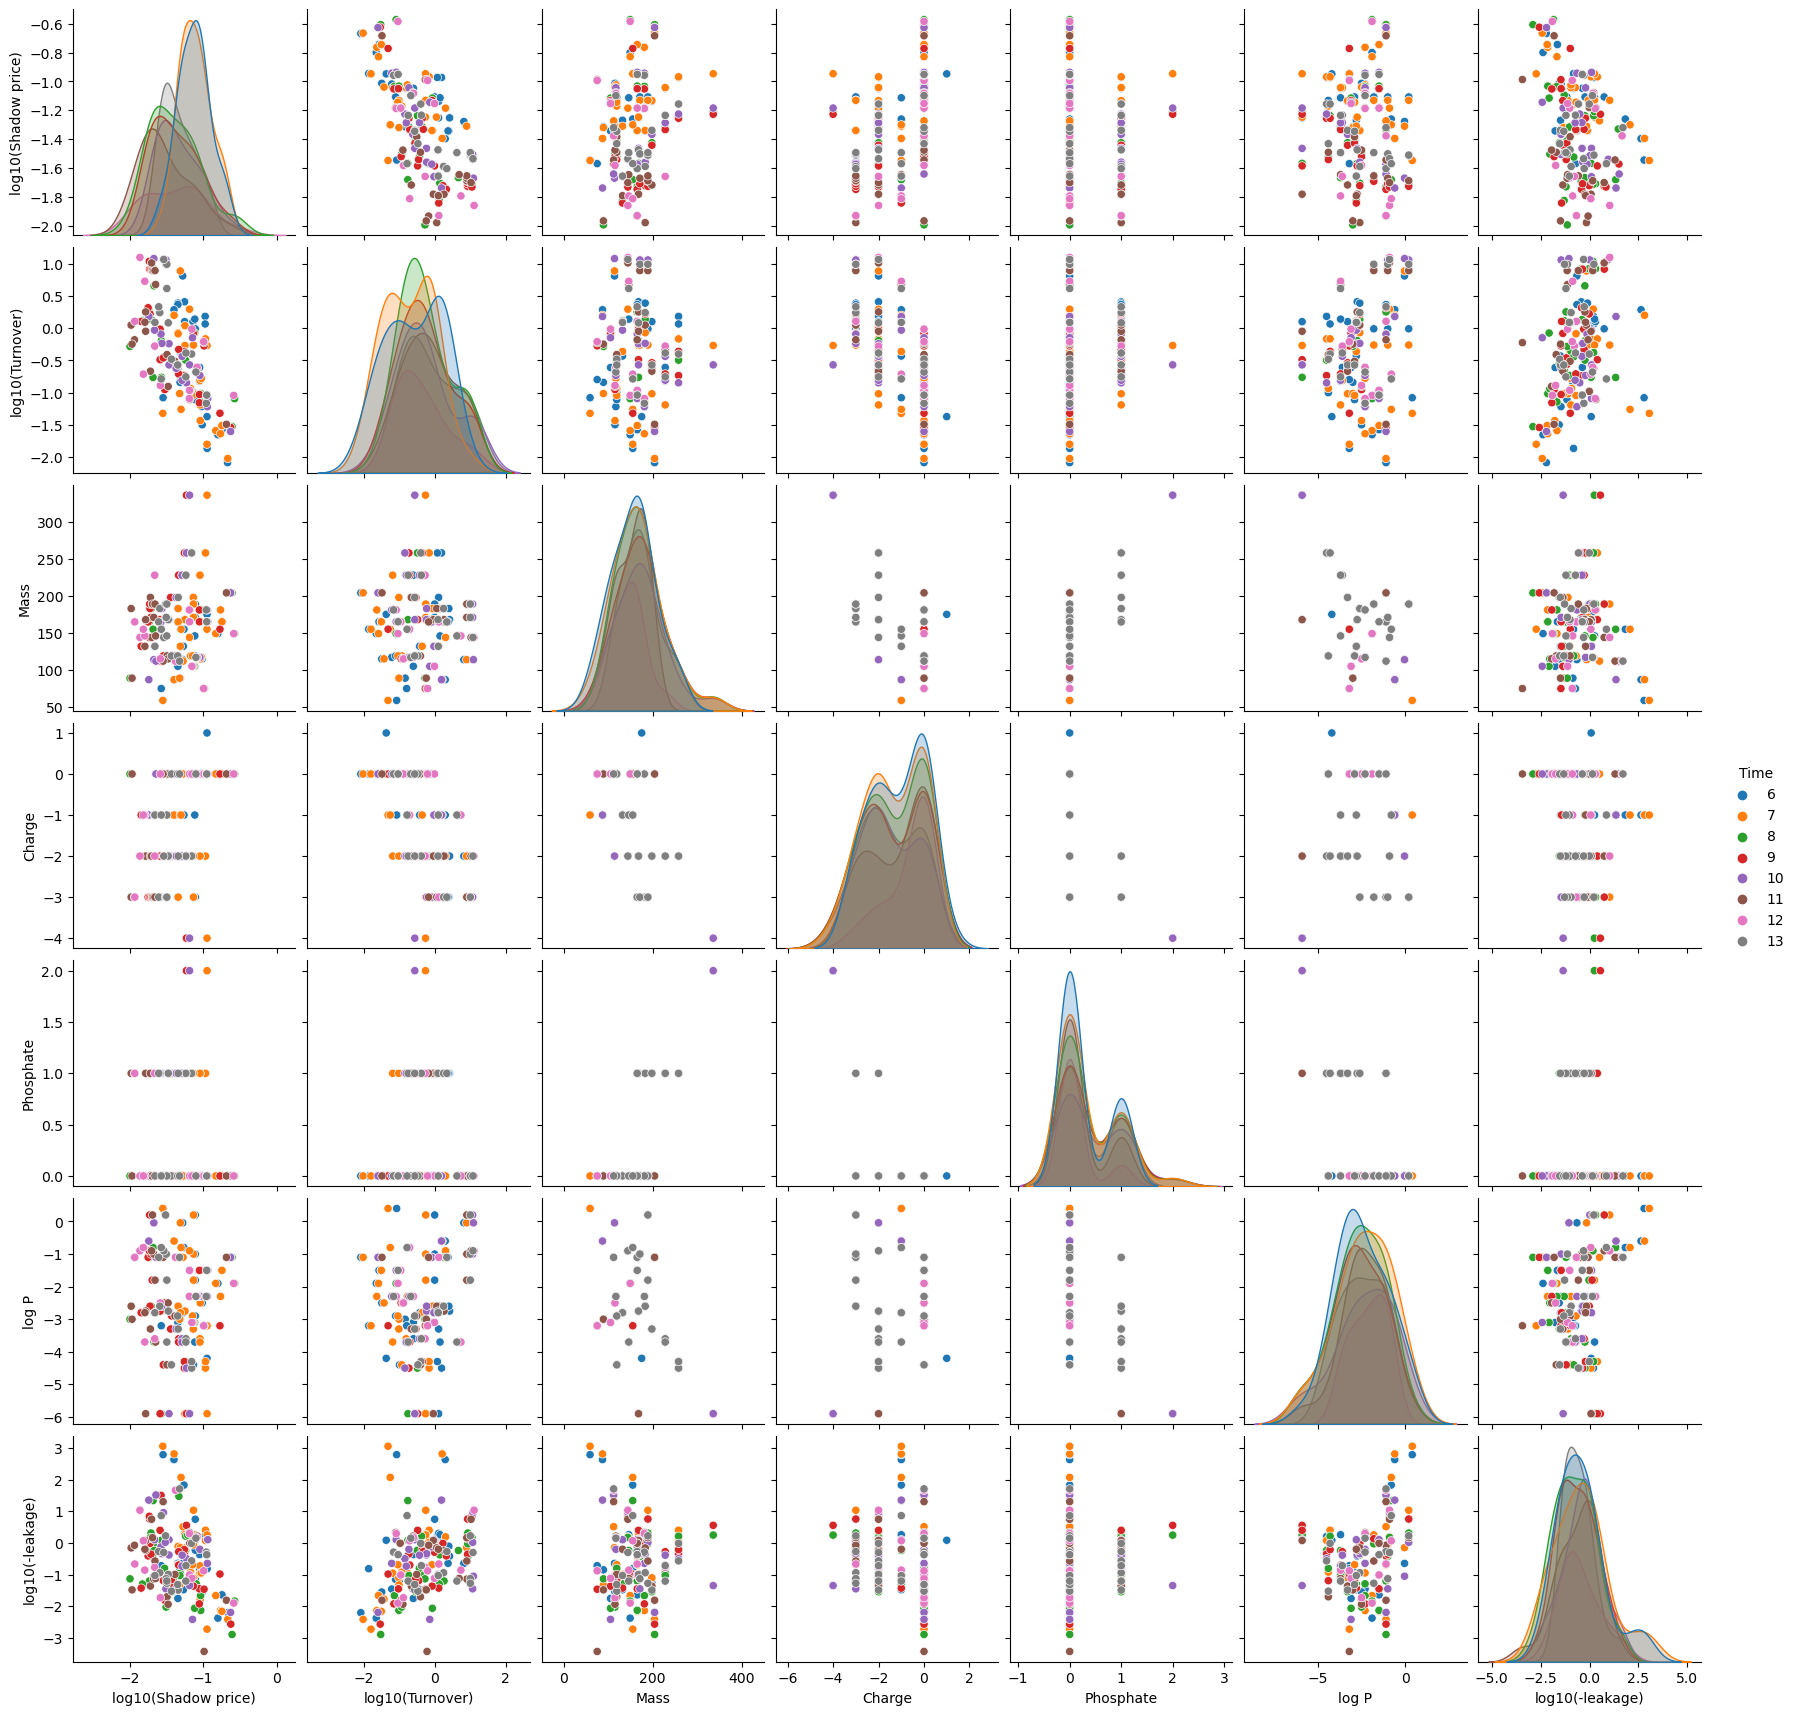

In [182]:

sns.pairplot(full_leakage[columns+['log10(-leakage)']], hue = 'Time', palette = "tab10")
plt.show()

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


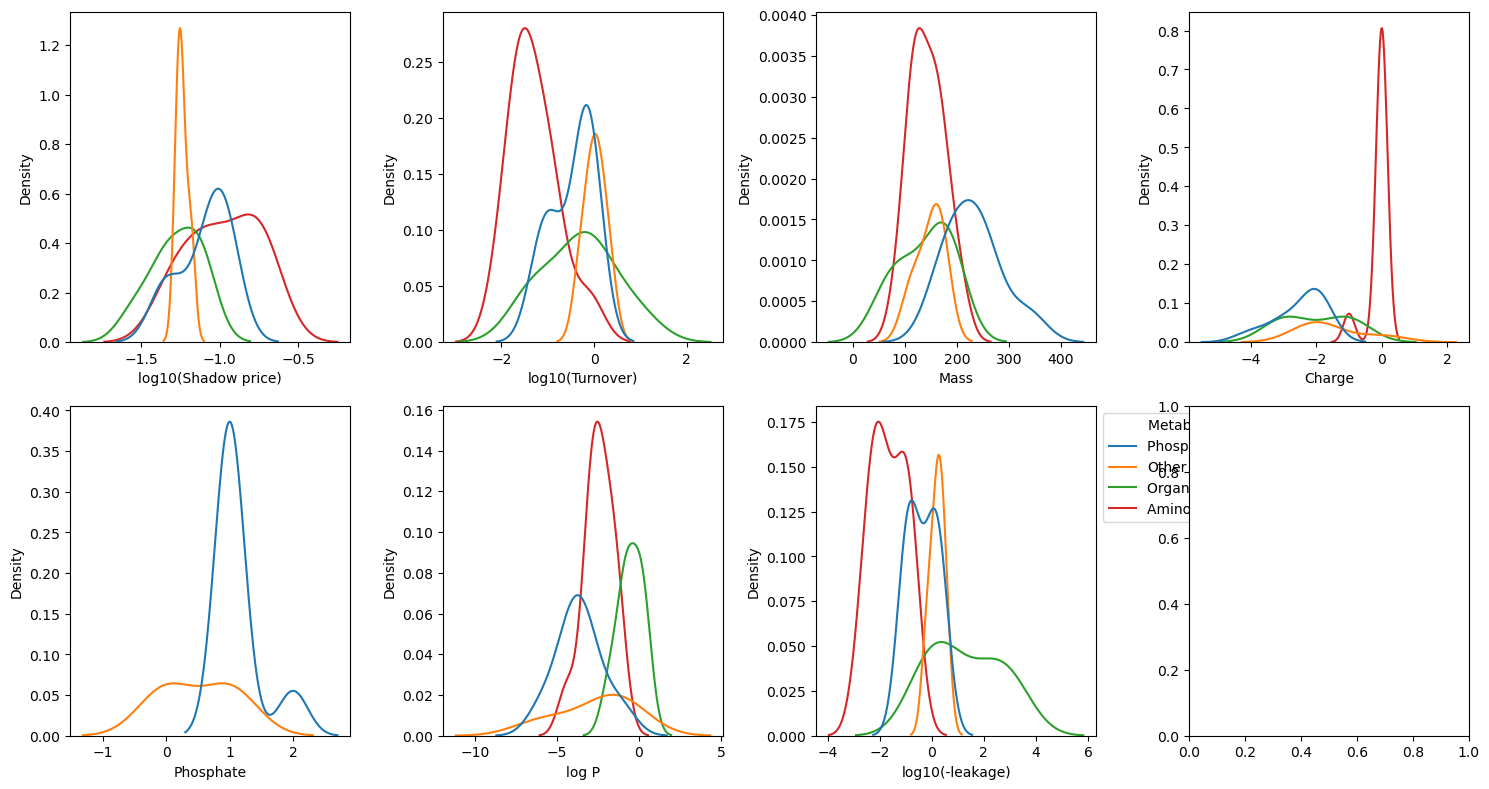

In [104]:
fig, axes = plt.subplots(2,4, figsize = (15, 8))
plot_columns = columns = ['log10(Shadow price)', "log10(Turnover)", "Mass", "Charge", "Phosphate", 'log P', 'log10(-leakage)']
axes = axes.flatten()
for i in range(7):            
        if i ==6:
            sns.kdeplot(data = full_leakage,x = plot_columns[i], hue = 'Metabolite class', ax = axes[i])
            break
        else:
            sns.kdeplot(data = full_leakage,x = plot_columns[i], hue = 'Metabolite class', ax = axes[i], legend=None)
plt.tight_layout()
sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1))
plt.savefig('distributions.svg')

In [ ]:
linear_reg = LinearRegression(fit_intercept = True).fit(full_leakage, y_train)

In [55]:
# sns.scatterplot(data = full_leakage, x = 'log P', y = 'log10(-leakage)', hue = 'Metabolite name')

In [56]:
full_leakage[columns+['log10(-leakage)', 'Metabolite id']]

,log10(Shadow price),log10(Turnover),Mass,Charge,Phosphate,log P,log10(-leakage),log10(-leakage),Metabolite id
0,-0.967852,-0.164342,258.119901,-2.0,1,-4.500,0.075425,0.075425,g6p
1,-0.967852,-0.164342,258.119901,-2.0,1,-4.300,0.401241,0.401241,f6p
2,-0.946454,-0.266888,336.083922,-4.0,2,-5.900,0.251057,0.251057,fdp
3,-1.247484,-0.266888,168.041961,-2.0,1,-5.900,0.269080,0.269080,dhap
4,-1.247484,0.041577,168.041961,-2.0,1,-2.750,-0.162575,-0.162575,g3p
5,-1.340238,-0.068796,183.033421,-3.0,1,-2.600,-0.112192,-0.112192,"2pg, 3pg"
6,-1.340238,-0.085063,165.018141,-3.0,1,-1.100,-0.689688,-0.689688,pep
7,-1.395285,0.221806,87.054120,-1.0,0,-0.600,2.811632,2.811632,pyr
8,-1.042668,-0.811104,228.093921,-2.0,1,-3.600,-0.723915,-0.723915,r5p
9,-1.042668,-1.192402,228.093921,-2.0,1,-3.700,-0.954538,-0.954538,"ru5p__D, ru5p__L, xu5p__D, xu5p__L"


In [81]:
full_leakage.loc[full_leakage['log10(Turnover)'] == -np.inf, 'log10(Turnover)'] = 0

In [97]:
columns = ['log10(Shadow price)', "log10(Turnover)", "Mass", "Charge", "Phosphate", 'log P']#,, "Growth rate" 'Metabolite class']#"Concentration", "Shadow price", "log10_conc", 'Growth rate', 


In [98]:
full_leakage.loc[30, ]
data = StandardScaler().fit_transform(full_leakage[columns])
X_train, X_test, y_train, y_test = train_test_split(data, full_leakage['log10(-leakage)'], test_size=0.1)#, random_state=40)


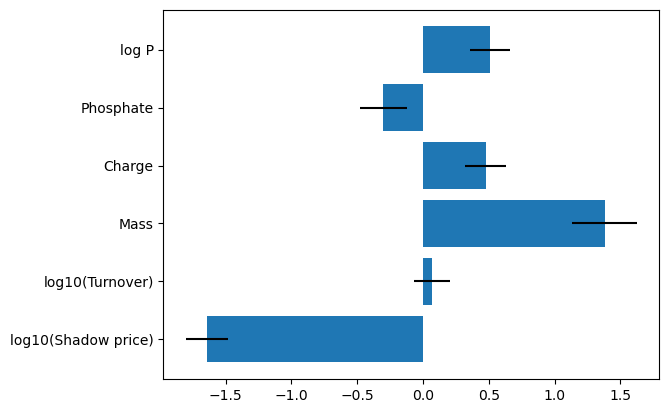

In [145]:
N = 100
coefficients = np.zeros((6,N))*np.nan

R2_arr_oo = np.zeros(N)
R2_arr = np.zeros(N)
R2_arr_test = np.zeros(N)
data = StandardScaler().fit_transform(full_leakage[columns])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, full_leakage['log10(-leakage)'], test_size=0.1)
    linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    coefficients[:, i] = linear_reg.coef_
    R2_arr[i] = linear_reg.score(X_train, y_train)
    R2_arr_oo[i] = linear_reg.score(X_test, y_test)

plt.barh(columns, coefficients.mean(axis=1), xerr = coefficients.std(axis=1))
plt.show()

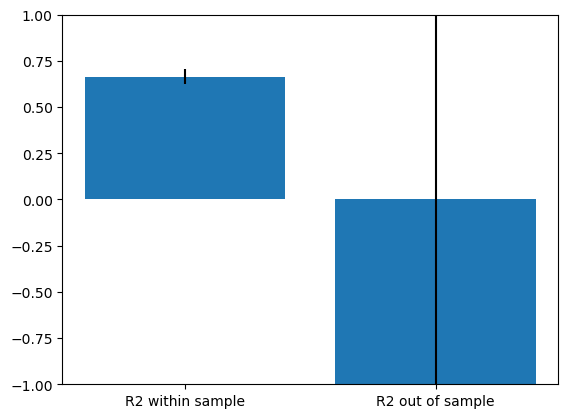

In [151]:
fig, ax = plt.subplots(1)
ax.bar(["R2 within sample", "R2 out of sample"], [R2_arr.mean(), R2_arr_oo.mean()], yerr = [R2_arr.std(), R2_arr_oo.std()])
ax.set_ylim(-1, 1)
plt.show()

In [93]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [94]:
df_i = full_leakage.loc[:, columns+['log10(-leakage)']]
rho = df_i.corr()
pval = df_i.corr(method=lambda x, y: st.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,log10(Shadow price),log10(Turnover),Mass,Charge,Phosphate,log P,Growth rate,log10(-leakage)
log10(Shadow price),1.0***,-0.59***,0.49**,0.29,-0.01,-0.22,nan,-0.7***
log10(Turnover),-0.59***,1.0***,0.04,-0.63***,0.28,0.03,nan,0.52**
Mass,0.49**,0.04,1.0***,-0.57***,0.75***,-0.55**,nan,-0.14
Charge,0.29,-0.63***,-0.57***,1.0***,-0.65***,0.13,nan,-0.42*
Phosphate,-0.01,0.28,0.75***,-0.65***,1.0***,-0.66***,nan,0.09
log P,-0.22,0.03,-0.55**,0.13,-0.66***,1.0***,nan,0.26
Growth rate,nan,nan,nan,nan,nan,nan,nan***,nan
log10(-leakage),-0.7***,0.52**,-0.14,-0.42*,0.09,0.26,nan,1.0***


In [96]:
pval.iloc[:, -1]

log10(Shadow price)    0.000010
log10(Turnover)        0.002483
Mass                   0.442383
Charge                 0.018926
Phosphate              0.628030
log P                  0.150905
Growth rate                 NaN
log10(-leakage)        0.000000
Name: log10(-leakage), dtype: float64

In [454]:
y = StandardScaler().fit_transform(full_leakage['log10(-leakage)'].values[:, np.newaxis])

In [ ]:
ols_model = sm.OLS(y, data)

In [ ]:
results = ols_model.fit()

In [ ]:
results.summary2()

In [ ]:
le = preprocessing.LabelEncoder()


In [108]:
columns = columns[:-1]

0.6686566160673145
0.33767536728703607


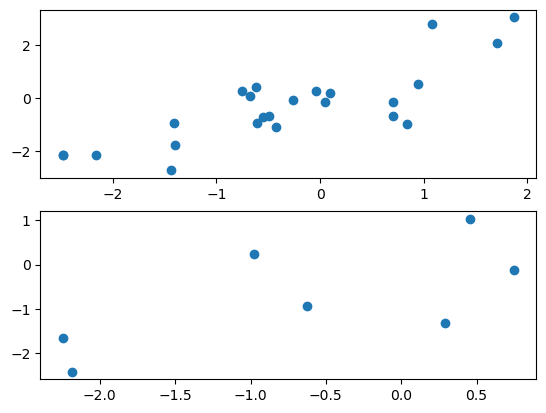

In [152]:
data = StandardScaler().fit_transform(full_leakage[columns])
X_train, X_test, y_train, y_test = train_test_split(data, full_leakage['log10(-leakage)'], test_size=0.2)#, random_state=40)

linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
lin_pred = linear_reg.predict(X_test)
print(linear_reg.score(X_train, y_train))
print(linear_reg.score(X_test, y_test))
fgi, (ax1,ax2) = plt.subplots(2)
ax1.scatter(linear_reg.predict(X_train), y_train)
ax2.scatter(linear_reg.predict(X_test), y_test)

0.6672923446414256
0.3264450863781704


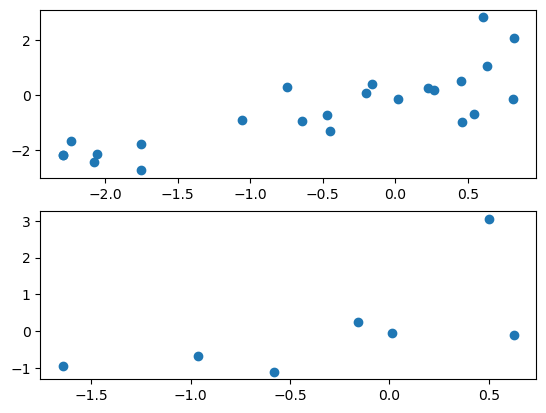

In [153]:
data = StandardScaler().fit_transform(full_leakage[columns])
X_train, X_test, y_train, y_test = train_test_split(data, full_leakage['log10(-leakage)'], test_size=0.2)#, random_state=40)

lasso_reg = Lasso(fit_intercept = True, alpha = 0.01).fit(X_train, y_train)
print(lasso_reg.score(X_train, y_train))
print(lasso_reg.score(X_test, y_test))
fgi, (ax1,ax2) = plt.subplots(2)
ax1.scatter(lasso_reg.predict(X_train), y_train)
ax2.scatter(lasso_reg.predict(X_test), y_test)

In [154]:
data = StandardScaler().fit_transform(full_leakage2[columns[:-1]+list(ohe_df.columns)])
X_train, X_test, y_train, y_test = train_test_split(data, full_leakage['log10(-leakage)'], test_size=0.1)#, random_state=40)

rf_reg = RandomForestRegressor().fit(X_train, y_train)
print(rf_reg.score(X_train, y_train))
print(rf_reg.score(X_test, y_test))
fgi, (ax1,ax2) = plt.subplots(2)
ax1.scatter(rf_reg.predict(X_train), y_train)
ax2.scatter(rf_reg.predict(X_test), y_test)

NameError: name 'ohe_df' is not defined

In [422]:
from sklearn.preprocessing import LabelBinarizer

jobs_encoder = LabelBinarizer()
jobs_encoder.fit(full_leakage['Metabolite class'])
transformed = jobs_encoder.transform(full_leakage['Metabolite class'])
ohe_df = pd.DataFrame(transformed)
full_leakage2 = pd.concat([full_leakage, ohe_df], axis=1).drop(['Metabolite class'], axis=1)
full_leakage2.columns = [str(x) for x in full_leakage2.columns]

In [414]:
met_ids = full_leakage['Metabolite name'].unique()


In [415]:
regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=300)

In [423]:
for m in met_ids:
    idx = full_leakage2['Metabolite name']==m
    X_train = full_leakage2.loc[~idx, columns[:-1]+[str(x) for x in ohe_df.columns]]
    X_test = full_leakage2.loc[idx, columns[:-1]+ [str(x) for x in ohe_df.columns]]
    # y_train = full_leakage.loc[~idx, 'Leakage (mM/gDW/h)']#'log10(-leakage)']
    # y_test = full_leakage.loc[idx, 'Leakage (mM/gDW/h)']#'log10(-leakage)']
    y_train = full_leakage2.loc[~idx, 'log10(-leakage)']
    y_test = full_leakage2.loc[idx, 'log10(-leakage)']
    
    # reg = MLPRegressor(max_iter = 1000, activation = 'logistic').fit(X_train, y_train)
    reg = RandomForestRegressor().fit(X_train, y_train)
    # reg = regr_2.fit(X_train, y_train)
    # reg = tree.DecisionTreeRegressor().fit(X_train, y_train)
    print(m)
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    

Glucose-6-phosphate
0.9759071895835556
0.7406579500201607
Fructose-6-phosphate
0.9744913025905382
-1.8572913959066506
Fructose-1,6-bisphosphate
0.9763780198427304
-0.015095986163104591
Dihydroxyacetonephosphate
0.9751707326167369
-51.9571406100797
Glyceraldehyde-3-phosphate
0.9760322403516531
-1.7335717056939801
2/3-phosphoglycerate
0.976330985716446
-0.12442559986603818
Phosphoenolpyruvate
0.9756138531869367
-3.350749276704877
Pyruvate
0.9763207108164837
-2.6565366969516457
Ribose-5-phosphate
0.9774635454356206
-0.5746264179504199
Ribu-/Xylulose-5-phosphate
0.9766257554963814
-0.1532511528983056
Erythrose-4-phosphate
0.978120235708279
-9.145988179197719
Citrate
0.9745233751590635
-9.521396611763317
Cis-aconitate
0.976080943667881
-1.223667035094687
Isocitrate
0.9763403203857505
0.10080591508812764
Fumarate
0.9802991118458869
-3.8579443021749666
Alanine
0.9778019276404425
0.0891562362425703
Valine
0.9788690506169813
-2.4167610640778086
Aspartate
0.9769102064382161
-0.4347701154143282
H

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Acetate
0.9750298164502917
-86.85773744835207
Orotate
0.9734520127547585
-1.1175075820930775
alpha-Ketoglutarate
0.9789102684471337
-14.425703346556842
Uracil
0.976729284018573
-40.10498728635628


In [424]:
for t in timepoints:
    idx = full_leakage['Time']==t
    X_train = full_leakage.loc[~idx, columns]
    X_test = full_leakage.loc[idx, columns]
    y_train = full_leakage.loc[~idx, 'log10(-leakage)']
    y_test = full_leakage.loc[idx, 'log10(-leakage)']
    reg = MLPRegressor(max_iter = 1000).fit(X_train, y_train)
    #reg = RandomForestRegressor().fit(X_train, y_train)
    # reg = tree.DecisionTreeRegressor().fit(X_train, y_train)
    print(m)
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    

ValueError: could not convert string to float: 'Glycolysis'

In [ ]:
full_leakage.loc[idx, columns]


In [ ]:
data = StandardScaler().fit_transform(full_leakage[columns])
X_train, X_test, y_train, y_test = train_test_split(data, full_leakage['log10(-leakage)'], test_size=0.2)#, random_state=40)

rf_reg = tree.DecisionTreeRegressor().fit(X_train, y_train)
print(rf_reg.score(X_train, y_train))
print(rf_reg.score(X_test, y_test))
fgi, (ax1,ax2) = plt.subplots(2)
ax1.scatter(rf_reg.predict(X_train), y_train)
ax2.scatter(rf_reg.predict(X_test), y_test)

In [ ]:
from sklearn.neural_network import MLPRegressor
data = StandardScaler().fit_transform(full_leakage[columns])
X_train, X_test, y_train, y_test = train_test_split(data, full_leakage['log10(-leakage)'], test_size=0.2)#, random_state=40)

rf_reg = MLPRegressor(max_iter = 1000).fit(X_train, y_train)
print(rf_reg.score(X_train, y_train))
print(rf_reg.score(X_test, y_test))
fgi, (ax1,ax2) = plt.subplots(2)
ax1.scatter(rf_reg.predict(X_train), y_train)
ax2.scatter(rf_reg.predict(X_test), y_test)